In [15]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt


In [17]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
tokenizer = get_tokenizer('basic_english')

array(['pericardial tamponade with clear distinction of epicardial border  and pericardium',
       'angiography of the aortic arch show delay visualization of the aberrant right subclavian artery arrow',
       'balloonocclude retrograde transvenous obliteration be attempt use a coaxial and double interruption system cytography be perform by insert the catheter into the shunt complete balloon occlusion be not achieve with a  balloon catheter arrow  the  mm balloon be inflate when the guide balloon catheter be fix at the optimum position arrow  follow which stasis of the contrast medium be observe we then perform balloonocclude retrograde transvenous obliteration use a sclerosing agent',
       ...,
       'preoperative cervical radiography lateral view of the cervical radiograph on the admission day reveal severe destruction of the vertebral body and kyphotic change at the  vertebral level',
       'first admission day brain ct scan show no haematoma',
       'radiograph of forelimb w

In [3]:
import pandas as pd
from pathlib import Path

data_path = Path.cwd().joinpath("data", "raw")
caption_prediction = data_path.joinpath("caption-prediction")
corpus = pd.read_csv(caption_prediction.joinpath("corpus.csv"), sep="\t").loc[:, "caption"].values

In [4]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

In [5]:
UNKNOWN_TOKEN = "<unk>"
START_TOKEN = "<sos>"
END_TOKEN = "<eos>"
PAD_TOKEN = "<pad>"

vocabulary = build_vocab_from_iterator(yield_tokens(corpus), specials=[UNKNOWN_TOKEN, START_TOKEN, END_TOKEN, PAD_TOKEN])
vocabulary.set_default_index(vocabulary[UNKNOWN_TOKEN])

In [30]:
vocabulary.get_itos()[:10]

['<unk>', '<sos>', '<eos>', '<pad>', 'the', 'of', 'show', 'and', 'a', 'in']

In [7]:
MAX_SEQ_LEN = 128 # should be the max length of the sentence in caption corpus

In [8]:
vocabulary.lookup_indices([START_TOKEN])[0]

1

In [32]:

vocabulary.__len__()

38357

[0, 0, 4, 0, 0]

In [9]:
from torchtext.transforms import Sequential, AddToken, Truncate, ToTensor, VocabTransform
add_token_start = AddToken(token=vocabulary.lookup_indices([START_TOKEN])[0], begin=True)
add_token_end = AddToken(token=vocabulary.lookup_indices([END_TOKEN])[0], begin=False)
text_tranform = Sequential(VocabTransform(vocabulary),
                           Truncate(max_seq_len=MAX_SEQ_LEN - 2),
                           add_token_start,
                           add_token_end,
                           ToTensor())

In [10]:
from src.data.dataloader import ImageCaptionDataset

In [11]:
training_dataset = ImageCaptionDataset(caption_path=caption_prediction.joinpath("training-captions.csv"),
                                       images_dir=data_path.joinpath("training-images"),
                                       sequence_length=200,
                                       text_tokenizer=tokenizer,
                                       text_transform=text_tranform)
                                      

In [12]:
validation_dataset = ImageCaptionDataset(caption_path=caption_prediction.joinpath("validation-captions.csv"),
                                       images_dir=data_path.joinpath("validation-images"),
                                       sequence_length=200,
                                       text_tokenizer=tokenizer,
                                       text_transform=text_tranform)

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence

def pad_sequences(batch):
    captions = []
    images = []
    for image, caption in batch:
        images.append(image)
        captions.append(caption)
    
    captions = pad_sequence(captions, batch_first=True, padding_value=vocabulary.lookup_indices([PAD_TOKEN])[0])
    images = torch.stack(images)
    return images.to(device), captions.to(device)

    
train_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, collate_fn=pad_sequences)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 64])


/var/folders/5_/n81dq93n79l30d_c34cfqxpr0000gn/T/ipykernel_12908/1892770973.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  plt.imshow(img.T)


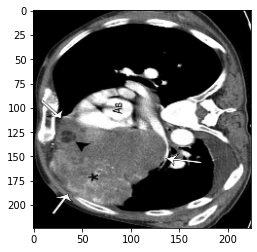

the caption indices are [   1  177   95   38   19   14   52   21 4407    4   50  225   22   12
  134    6  538  964 1112    7  232  110   10    8  538 1496  303 1303
  134    4  170  390   86    4   69  102  100   11  171  711   23 1779
   14   11  726   29    2    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3]
the caption text is ['<sos>', 'followup', 'contrastenhance', 'compute', 'tomography', 'ct', 'imaging', 'at', 'threemonth', 'the', 'anterior', 'mediastinal', 'mass', 'arrow', 'also', 'show', 'marked', 'interval', 'growth', 'and', 'heterogeneous', 'enhancement', 'with', 'a', 'marked', 'hypervascular', 'portion', 'asterbek', 'also', 'the', 'fat', 'component', 'within', 'the', 'tumor', 'arrowhead', 'which', 'be', 'not', 'clear', 'on', 'baseline', 'ct', 'be', 'clearly', 'demonstrate', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [18]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
label = label.numpy()
plt.imshow(img.T)
plt.show()
print(f"the caption indices are {label}")
print(f"the caption text is {vocabulary.lookup_tokens(label)}")

{'id': 5, '<unk>': 0, 'caption': 4, '<pad>': 3, '<eos>': 2, '<sos>': 1}

In [19]:
from src.models.models import EncoderCNN, DecoderRNN

In [21]:
encoder = EncoderCNN(embedding_size=512)
decoder = DecoderRNN(embed_size=512, hidden_size=512, vocab_size=2500)

In [23]:
train_image, train_caption = next(iter(train_dataloader))

In [24]:

input_names = ['images']
output_names = ['images_vectors']
torch.onnx.export(encoder, train_image, 'encoder_cnn.onnx', input_names=input_names, output_names=output_names)

In [33]:
print(decoder)

DecoderRNN(
  (lstm): LSTM(512, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (embed): Embedding(2500, 512)
  (linear): Linear(in_features=512, out_features=2500, bias=True)
)


In [37]:
# Example of target with class indices
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

# Example of target with class probabilities


In [38]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [39]:
print("the input is ", input)
print("the target is ", target)
output = loss(input, target)
output.backward()
print( "the loss is ", output)

the input is  tensor([[ 0.8538, -0.2625, -2.1512, -0.1095, -2.2551],
        [-0.0858,  0.3443, -0.8959,  1.1365, -3.1316],
        [ 0.9425,  0.3207, -0.6297, -0.2078, -0.1309]], requires_grad=True)
the target is  tensor([[0.2626, 0.3343, 0.2813, 0.0478, 0.0740],
        [0.2865, 0.0296, 0.2751, 0.3612, 0.0476],
        [0.0910, 0.1134, 0.0115, 0.3401, 0.4439]])
the loss is  tensor(1.8970, grad_fn=<DivBackward1>)


In [44]:
a = [[1, 2], [1, 3], [4,5]]
b = torch.IntTensor(a)

In [46]:
a = [[[1], [2]], [[1], [3]], [[4], [5]]]

In [54]:
b = torch.FloatTensor(a)

In [48]:
b.shape

torch.Size([3, 2, 1])

In [55]:
b = b.reshape(3, 1, 2)

In [57]:
b.reshape(-1, 2).shape

torch.Size([3, 2])

In [61]:
sum([73, 24, 17, 16, 12])

142